In [1]:
from src.defaults import *
from src.datasets.novelty import *

In [2]:
load_nli = 'NLI-92'

download_models_from_neptune(load_nli)
field = load_field(load_nli)
# field = None


dataset_conf = {'dataset': 'dlnd', 'max_num_sent': 60,"sent_tokenizer":"spacy","batch_size":4,"device":"cuda"}
# dataset_conf = {'dataset': 'dlnd', 'max_num_sent': 50,"sent_tokenizer":"spacy", "tokenizer":'spacy',"max_len":50,"batch_size":32,"device":"cuda"}
model_conf = {'results_dir': 'results', 'device': 'cuda', 'dropout': 0.2, 'dataset': 'dlnd', 'hidden_size': 150, 'use_glove': False}

In [3]:
data = dlnd(dataset_conf,sentence_field = field)

In [4]:
for i in data.train_iter:
    print(i)
    break


[torchtext.data.batch.Batch of size 4]
	[.source]:[torch.cuda.LongTensor of size 4x60x50 (GPU 0)]
	[.target]:[torch.cuda.LongTensor of size 4x60x50 (GPU 0)]
	[.label]:[torch.cuda.LongTensor of size 4 (GPU 0)]


In [5]:
from src.model.nli_models import *
from src.model.novelty_models import *

def load_encoder(enc_data):
    if enc_data['options'].get("attention_layer_param",0)==0:
        model = bilstm_snli(enc_data["options"])
    elif enc_data['options'].get("r",0)==0:
        model = attn_bilstm_snli(enc_data["options"])
    else:
        model = struc_attn_snli(enc_data["options"])
    return model

nli_model_data = load_encoder_data(load_nli)
nli_model_data['options']["use_glove"] = False
encoder = load_encoder(nli_model_data).encoder
model_conf["encoder_dim"] = nli_model_data["options"]["hidden_size"]



In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class concat_attention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.Wc1 = nn.Linear(2 * hidden_size, hidden_size, bias=False)
        self.Wc2 = nn.Linear(2 * hidden_size, hidden_size, bias=False)
        self.vc = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, x, y):
        _s1 = self.Wc1(x).unsqueeze(1)
        _s2 = self.Wc2(y).unsqueeze(2)
        sjt = self.vc(torch.tanh(_s1 + _s2)).squeeze()
        ait = F.softmax(sjt, 2)
        qtc = ait.bmm(x)
        return qtc


class bilinear_attention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.Wb = nn.Linear(2 * hidden_size, 2 * hidden_size, bias=False)

    def forward(self, x, y):
        _s1 = self.Wb(x).transpose(2, 1)
        sjt = y.bmm(_s1)
        ait = F.softmax(sjt, 2)
        qtb = ait.bmm(x)
        return qtb


class dot_attention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.Wd = nn.Linear(2 * hidden_size, hidden_size, bias=False)
        self.vd = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, x, y):
        _s1 = x.unsqueeze(1)
        _s2 = y.unsqueeze(2)
        sjt = self.vd(torch.tanh(self.Wd(_s1 * _s2))).squeeze()
        ait = F.softmax(sjt, 2)
        qtd = ait.bmm(x)
        return qtd


class minus_attention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.Wm = nn.Linear(2 * hidden_size, hidden_size, bias=False)
        self.vm = nn.Linear(hidden_size, 1, bias=False)

        self.Ws = nn.Linear(2 * hidden_size, hidden_size, bias=False)
        self.vs = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, x, y):
        _s1 = x.unsqueeze(1)
        _s2 = y.unsqueeze(2)
        sjt = self.vm(torch.tanh(self.Wm(_s1 - _s2))).squeeze()
        ait = F.softmax(sjt, 2)
        qtm = ait.bmm(x)
        return qtm


class MwAN(nn.Module):
    def __init__(self, conf, encoder):
        super().__init__()
        self.conf = conf
        self.dropout = nn.Dropout(conf["dropout"])
        self.encoder = encoder
        self.template = nn.Parameter(torch.zeros((1)), requires_grad=True)
        self.prem_gru = nn.GRU(
            input_size=2 * self.conf["encoder_dim"],
            hidden_size=self.conf["hidden_size"],
            batch_first=True,
            bidirectional=True,
        )

        self.hypo_gru = nn.GRU(
            input_size=2 * self.conf["encoder_dim"],
            hidden_size=conf["hidden_size"],
            batch_first=True,
            bidirectional=True,
        )

        # Concat Attention
        self.concat_attn = concat_attention(conf["hidden_size"])
        # Bilinear Attention
        self.bilinear_attn = bilinear_attention(conf["hidden_size"])
        # Dot Attention :
        self.dot_attn_1 = dot_attention(conf["hidden_size"])
        self.dot_attn_2 = dot_attention(conf["hidden_size"])
        # Minus Attention :
        self.minus_attn = minus_attention(conf["hidden_size"])

        self.gru_agg = nn.GRU(
            12 * conf["hidden_size"],
            conf["hidden_size"],
            batch_first=True,
            bidirectional=True,
        )

        self.Wq = nn.Linear(2 * conf["hidden_size"], conf["hidden_size"], bias=False)
        self.vq = nn.Linear(conf["hidden_size"], 1, bias=False)

        self.Wp1 = nn.Linear(2 * conf["hidden_size"], conf["hidden_size"], bias=False)
        self.Wp2 = nn.Linear(2 * conf["hidden_size"], conf["hidden_size"], bias=False)
        self.vp = nn.Linear(conf["hidden_size"], 1, bias=False)

        self.prediction = nn.Linear(2 * conf["hidden_size"], 2, bias=False)

    def encode_sent(self, inp):
        batch_size, num_sent, max_len = inp.shape
        x = inp.view(-1, max_len)

        x_padded_idx = x.sum(dim=1) != 0
        x_enc = []
        for sub_batch in x[x_padded_idx].split(64):
            x_enc.append(self.encoder(sub_batch, None))
        x_enc = torch.cat(x_enc, dim=0)

        x_enc_t = torch.zeros((batch_size * num_sent, x_enc.size(1))).to(
            self.template.device
        )

        x_enc_t[x_padded_idx] = x_enc
        x_enc_t = x_enc_t.view(batch_size, num_sent, -1)

        return x_enc_t

    def forward(self, input):
        x0,x1 = input
        x0_enc = self.encode_sent(x0)
        x1_enc = self.encode_sent(x1)

        x0_enc, _ = self.prem_gru(x0_enc)
        x1_enc, _ = self.hypo_gru(x1_enc)

        qtc = self.concat_attn(x0_enc, x1_enc)
        qtb = self.bilinear_attn(x0_enc, x1_enc)
        qts = self.dot_attn_1(x0_enc, x1_enc)
        qtd = self.dot_attn_2(x1_enc, x0_enc)
        qtm = self.minus_attn(x0_enc, x1_enc)

        aggregation = torch.cat([x1_enc, qts, qtc, qtd, qtb, qtm], 2)
        aggregation_representation, _ = self.gru_agg(aggregation)

        sj = self.vq(torch.tanh(self.Wq(x0_enc))).transpose(2, 1)
        rq = F.softmax(sj, 2).bmm(x0_enc)
        sj = F.softmax(
            self.vp(self.Wp1(aggregation_representation) + self.Wp2(rq)).transpose(
                2, 1
            ),
            2,
        )
        rp = sj.bmm(aggregation_representation)
        encoder_output = self.dropout(F.relu(self.prediction(rp)))
        encoder_output = encoder_output.squeeze(1)
        return encoder_output


In [7]:
model = MwAN(model_conf,encoder)

In [8]:
train_dl,val_dl,test_dl = data.get_dataloaders()


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.59E-01


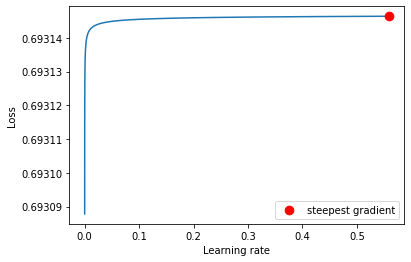

In [11]:
from torch_lr_finder import LRFinder

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)
# optimizer = optim.Adadelta(model.parameters(),lr = 0.01,)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_dl, val_loader=val_dl, end_lr=0.001, num_iter=100, step_mode="exp")
lr_finder.plot(log_lr=False)
lr_finder.reset()


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.53E-01


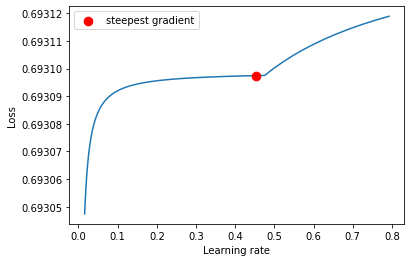

In [10]:
from torch_lr_finder import LRFinder

criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.0001)
optimizer = optim.Adadelta(model.parameters(),lr = 0.01,)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_dl, val_loader=val_dl, end_lr=1, num_iter=100, step_mode="exp")
lr_finder.plot(log_lr=False)
lr_finder.reset()

In [10]:
for i in train_dl:
    print(i)
    break

[[tensor([[[    2,    14,     4,  ...,     1,     1,     1],
         [    2,     6,  7893,  ...,     1,     1,     1],
         [    2, 16905,    18,  ...,     1,     1,     1],
         ...,
         [    2,     6,    53,  ...,     1,     1,     1],
         [    2,     6,     0,  ...,     0,    89,     3],
         [    2,   631,    13,  ...,     1,     1,     1]],

        [[    2,  9303, 17679,  ...,     1,     1,     1],
         [    2,     6,  3794,  ...,     1,     1,     1],
         [    2, 17679,    89,  ...,     1,     1,     1],
         ...,
         [    1,     1,     1,  ...,     1,     1,     1],
         [    1,     1,     1,  ...,     1,     1,     1],
         [    1,     1,     1,  ...,     1,     1,     1]],

        [[    2,  9113,    45,  ...,  8569,     0,     3],
         [    2,     0,     0,  ...,     1,     1,     1],
         [    2,   136,   575,  ...,     1,     1,     1],
         ...,
         [    1,     1,     1,  ...,     1,     1,     1],
        

In [18]:
model.conf

{'attention_layer_param': 200,
 'char_embedding_dim': 100,
 'dataset': 'snli',
 'device': 'cuda',
 'dropout': 0.3,
 'embedding_dim': 300,
 'fcs': 1,
 'hidden_size': 400,
 'max_word_len': 10,
 'num_layers': 1,
 'padding_idx': 1,
 'results_dir': 'results',
 'use_char_emb': False,
 'use_glove': False,
 'vocab_size': 33934}

In [41]:
from sklearn.model_selection import KFold,StratifiedKFold
import numpy as np
from torchtext.data import Dataset


def iter_folds(data):
    kf = StratifiedKFold(n_splits=10, shuffle=True)
    train_exs_arr = np.array(data.data.examples)
    labels = np.array([i.label for i in data.data.examples])
    fields = data.data.fields
    for train_idx, val_idx in kf.split(train_exs_arr,y = labels):
        yield (
            Dataset(train_exs_arr[train_idx], fields),
            Dataset(train_exs_arr[val_idx], fields),
        )


In [42]:
for i in iter_folds(data):
    print(i)

(<torchtext.data.dataset.Dataset object at 0x7fb59a014ef0>, <torchtext.data.dataset.Dataset object at 0x7fb5991c9ba8>)
(<torchtext.data.dataset.Dataset object at 0x7fb59a031898>, <torchtext.data.dataset.Dataset object at 0x7fb5991c93c8>)
(<torchtext.data.dataset.Dataset object at 0x7fb59a014ef0>, <torchtext.data.dataset.Dataset object at 0x7fb5991c9ba8>)
(<torchtext.data.dataset.Dataset object at 0x7fb59a031898>, <torchtext.data.dataset.Dataset object at 0x7fb5991c93c8>)
(<torchtext.data.dataset.Dataset object at 0x7fb59a014ef0>, <torchtext.data.dataset.Dataset object at 0x7fb5991c9ba8>)
(<torchtext.data.dataset.Dataset object at 0x7fb59a031898>, <torchtext.data.dataset.Dataset object at 0x7fb5991c93c8>)
(<torchtext.data.dataset.Dataset object at 0x7fb59a014ef0>, <torchtext.data.dataset.Dataset object at 0x7fb5991c9ba8>)
(<torchtext.data.dataset.Dataset object at 0x7fb59a031898>, <torchtext.data.dataset.Dataset object at 0x7fb5991c93c8>)
(<torchtext.data.dataset.Dataset object at 0x7fb